/tmp/ipykernel_2258087/1412577023.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)


Epoch 1/10, Diffusion Loss: 3255.8226
Epoch 2/10, Diffusion Loss: 3273.6461
Epoch 3/10, Diffusion Loss: 3249.6910
Epoch 4/10, Diffusion Loss: 3309.4632
Epoch 5/10, Diffusion Loss: 3324.2418
Epoch 6/10, Diffusion Loss: 3239.1211
Epoch 7/10, Diffusion Loss: 3222.9325
Epoch 8/10, Diffusion Loss: 3332.5394
Epoch 9/10, Diffusion Loss: 3325.5199
Epoch 10/10, Diffusion Loss: 3341.0771


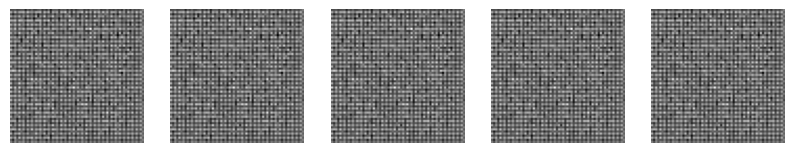

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import tifffile as tiff
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Custom Dataset Loader for Unlabeled TIFF Images
class UnlabeledTIFFDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.lower().endswith(('tif', 'tiff'))]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = tiff.imread(img_path).astype(np.float32)
            image = image / 255.0
            if image.ndim == 3:
                image = image[0]
        except Exception as e:
            print(f"Warning: Skipping unreadable image {img_path} - {e}")
            return self.__getitem__((idx + 1) % len(self.image_paths))
        
        if self.transform:
            image = self.transform(image)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        image = image.squeeze(1)
        return image, 0

# Step 1: Define the Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z).view(-1, 128, 8, 8)
        return self.decoder(x), mu, logvar

# Step 2: Define the Diffusion Model
class DiffusionModel(nn.Module):
    def __init__(self, latent_dim=32, timesteps=100):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.denoise_net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
    
    def forward(self, z, t):
        noise = torch.randn_like(z)
        return self.denoise_net(z) + noise * t.view(-1, 1)

# Step 3: Train the Diffusion Model
def train_diffusion(diff_model, vae, dataloader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(diff_model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    for epoch in range(epochs):
        diff_model.train()
        total_loss = 0.0
        for x, _ in dataloader:
            x = x.to(device)
            _, mu, _ = vae(x)
            t = torch.randint(0, diff_model.timesteps, (mu.size(0),), device=device).float()
            noisy_latent = mu + torch.randn_like(mu) * (t.view(-1, 1) / diff_model.timesteps)
            denoised_latent = diff_model(noisy_latent, t)
            loss = loss_fn(denoised_latent, mu)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Diffusion Loss: {avg_loss:.4f}")

# Step 4: Generate Images from Diffused Latents
def sample_latents(diff_model, num_samples=5):
    z = torch.randn(num_samples, diff_model.denoise_net[0].in_features).to(device)
    for t in reversed(range(diff_model.timesteps)):
        t_tensor = torch.full((num_samples, 1), t / diff_model.timesteps, device=device)
        z = diff_model(z, t_tensor)
    return z

def generate_images(vae, diff_model, num_samples=5):
    latents = sample_latents(diff_model, num_samples)
    with torch.no_grad():
        decoded_images = vae.decoder(vae.fc_decode(latents).view(-1, 128, 8, 8)).cpu()
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
    for i, img in enumerate(decoded_images):
        axes[i].imshow(img.squeeze().numpy(), cmap="gray")
        axes[i].axis("off")
    plt.show()

# Load Data and Train Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/mnt/d/lding/FA/analysis_results/encoder/partitioned_data_rand_flow/annabel_0226_patchsize_64'
transform = transforms.Compose([transforms.ToTensor()])
dataset = UnlabeledTIFFDataset(root_dir=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE().to(device)
diffusion_model = DiffusionModel().to(device)
train_diffusion(diffusion_model, vae, dataloader)
generate_images(vae, diffusion_model)
